In [17]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import numpy as np
import matplotlib.pyplot as plt

In [5]:
united_norm_encoded = pd.read_csv('united_norm_encoded.csv')
y_train = pd.read_csv('y_train.csv')
sk_id_curr = united_norm_encoded['SK_ID_CURR']

ntest = 48744
# выберем топ лучших признаков, исходя из feature_importance из прошлой дз для 
# уменьшения времени обучения
united_norm_encoded = united_norm_encoded.loc[:, ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 
                                                  'NAME_EDUCATION_TYPE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_CREDIT', 'DAYS_ID_PUBLISH',
                                                  'AMT_GOODS_PRICE', 'CODE_GENDER', 'AMT_ANNUITY', 'REGION_RATING_CLIENT_W_CITY',
                                                  'ORGANIZATION_TYPE', 'DAYS_REGISTRATION', 'REGION_RATING_CLIENT']]
x_train = united_norm_encoded[ntest:]
x_test = united_norm_encoded[:ntest]

In [33]:
def grid_search_with_one_param(param_name: str, values:list):
  kf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=x_train, y=y_train)
  lgb_estimator = lgb.LGBMClassifier(objective='binary', metric='auc')

  param_grid = {
      param_name: values
      }
  gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid,
                                  cv=kf, return_train_score=True)
  gsearch.fit(x_train, np.ravel(y_train))

  plt.xlabel(param_name)
  plt.ylabel("score")
  test_line, = plt.plot(param_grid[param_name], gsearch.cv_results_['mean_test_score']);
  train_line, = plt.plot(param_grid[param_name],gsearch.cv_results_['mean_train_score']);
  plt.legend((test_line, train_line), ('test', 'train'));

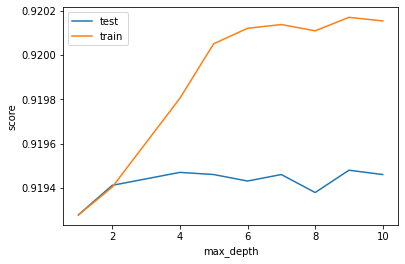

In [34]:
grid_search_with_one_param('max_depth', [1, 2, 4, 5, 6, 7, 8, 9, 10])

CPU times: user 7min 29s, sys: 1.59 s, total: 7min 31s
Wall time: 4min 1s


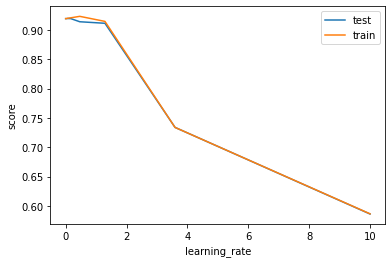

In [35]:
%%time
grid_search_with_one_param('learning_rate', np.logspace(-3, 1, 10))

CPU times: user 4min 54s, sys: 1.05 s, total: 4min 55s
Wall time: 2min 39s


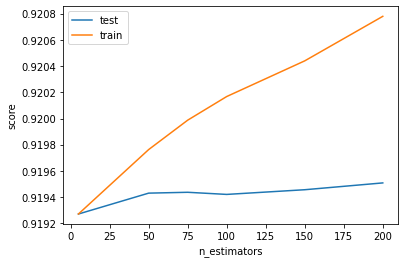

In [37]:
%%time
grid_search_with_one_param('n_estimators', [5, 50, 75, 100, 150, 200])

Выберем следующие параметры:
  * max_depth: 6
  * learning_rate: 0.0027
  * n_estimators: 100





In [6]:
%%time
lgb_estimator = lgb.LGBMClassifier(objective='binary', metric='auc', max_depth=6, learning_rate=0.0027, n_estimators=100)
lgb_estimator.fit(x_train, np.ravel(y_train));

CPU times: user 9.76 s, sys: 51.2 ms, total: 9.81 s
Wall time: 5.07 s


Посмотрим на лучшие признаки

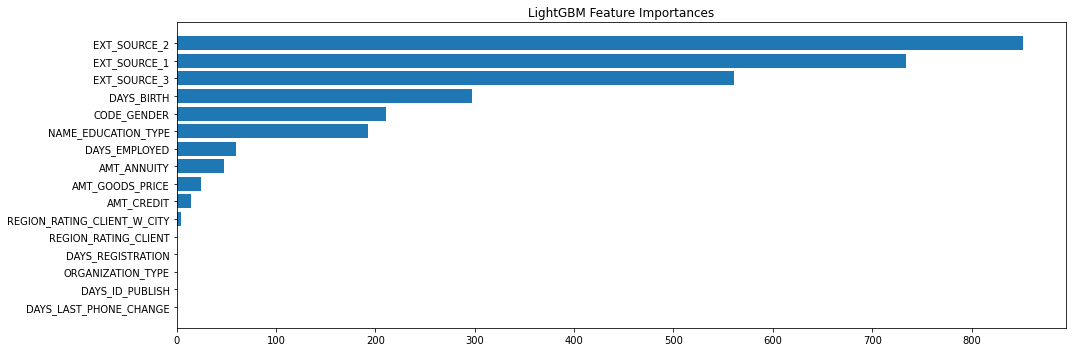

In [48]:
feature_names = np.r_[x_train.columns]
sorted_idx = lgb_estimator.feature_importances_.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(15,5))
ax.barh(y_ticks, lgb_estimator.feature_importances_[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("LightGBM Feature Importances")
fig.tight_layout()
plt.show()

Как и до этого, лучшими оказались **EXT_SOURCE_*** + **возраст** + **пол**

In [7]:
# 0.70994
best_lgb_res = lgb_estimator.predict_proba(x_test)[:, 1]

Построим стекинг на 5 моделях:
 * RandomForest(n_estimators=50, random_state=42, max_depth=8)
 * LGB (см. выше)
 * LogisticRegression(penalty='l1', solver='saga')
 * RandomForestClassifier(n_estimators=100, random_state=42, max_depth=6)
 * LogisticRegression(C=0.1)




In [20]:
%%time
estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42, max_depth=8)),
    ('lgb_boost', lgb.LGBMClassifier(objective='binary', metric='auc', max_depth=6, learning_rate=0.0027, n_estimators=100)),
    ('log_reg', LogisticRegression(penalty='l1', solver='saga')),
    ('rf_2', RandomForestClassifier(n_estimators=100, random_state=42, max_depth=6))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(C=0.1)
)
clf.fit(x_train, np.ravel(y_train))

CPU times: user 9min 17s, sys: 2.25 s, total: 9min 20s
Wall time: 8min 54s


In [21]:
# 0.72605
stacking_model = clf.predict_proba(x_test)[:, 1]

Теперь уберем лучшую модель

In [24]:
%%time
estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42, max_depth=8)),
    ('lgb_boost', lgb.LGBMClassifier(objective='binary', metric='auc', max_depth=6, learning_rate=0.0027, n_estimators=100)),
    ('rf_2', RandomForestClassifier(n_estimators=100, random_state=42, max_depth=6))
]
clf_2 = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(C=0.1)
)
clf_2.fit(x_train, np.ravel(y_train))

CPU times: user 7min 29s, sys: 1.36 s, total: 7min 30s
Wall time: 7min 5s


In [25]:
# 0.72281
stacking_model_2 = clf_2.predict_proba(x_test)[:, 1]

Скор упал, что неудивительно
